In [1]:
from sav_extract import sav_extract
filename='iris2model_multi.sav'
iris2modelarray=sav_extract(filename)

Your file iris2model_multi.sav contains an inversion of 18 rasters, no raster number was selected so will return numpy.recarray of all 18 rasters...
...with the required structure


In [2]:
from data_extract import tag_extract, kpeak_ind_extract, trimmed_rows, data_trim

ras1=iris2modelarray[0]
wavelength  = tag_extract(ras1,'wl')
kpeak_ind   = kpeak_ind_extract(wavelength)

iris_cal_list=[]
for record in iris2modelarray:
    iris_cal_untrimmed=(tag_extract(record,'iris_cal')) # then this one to get trimmed rows from kpeak frame
#     print(iris_cal_untrimmed.shape)
    frame       = iris_cal_untrimmed[kpeak_ind,...] # create a frame at this peak wavelength, where FL is most visible
    rows=trimmed_rows(frame) # cuts FOV to only include observed data, not zeros at top and bottom (returns list of top and bottom row)
    iris_cal_list.append(data_trim(iris_cal_untrimmed, rows,'iris_cal'))


iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been trimmed to (217, 183, 32)
iris_cal has successfully been 

# Make list of original frames

In [3]:
frame_list=[]
for raster in iris_cal_list:
    frame_list.append(raster[kpeak_ind])
# could make into function

# Frame cleaning
---

## Slit row extraction function

In [4]:
# make slit row a function

import numpy as np
import scipy.stats as stats

def slit_row_extract(frame):
    '''
    Extract the index of the row with the slit in it from monochromatic image.
    Works by getting the row index of the min val in each col and taking the most common
    row value from that list
    '''
    slit_rows=[]
    for col in range(frame.shape[1]):
        slit_rows.append(np.argmin(frame[:,col]))
    slit_row=int(stats.mode(slit_rows)[0])
    return slit_row

## Threshold extraction function (using hist)

In [5]:
import numpy as np # explicitly state package dependencies for each sep function
from scipy.signal import find_peaks

def thresh_extract(frame,slit_row):
    '''
    Extract flat threshold frame for filament sep from k3 monochromatic frame.
    It does this by raising slit vals to a max value so the first trough of histogram 
    is roughly the threshold between filamenty and quiet sun.
    (Only tested for quiet sun filament obs as of 21/09/2020)
    '''
    ### raise slit vals to max for hist peaks
    frame[slit_row,:]=np.amax(frame) 
    frame[slit_row-1,:]=np.amax(frame)

    ### then do find peaks for thresh here:
    frame_linear=np.reshape(frame,-1)
    bin_number=int(len(frame_linear)/80) # 80 decided empirically to give consistently good peaks
    hist,bins = np.histogram(frame_linear, bins = bin_number) # iteratively decided on 70 bins
    bin_centres = 0.5*(bins[1:]+bins[:-1])

    peaks, _ = find_peaks(-hist) # find troughs
    index=peaks[0] # since bin size is so big, first trough corresponds to post-FL dip.
    thresh=bin_centres[index] 
    frame[frame>thresh]=0
    return frame


## Binary mask extraction function

In [6]:
import numpy as np
from scipy.signal import medfilt

def bin_mask_extract(frame,slit_row=None):
    '''
    Exracts binary mask array-like 1s for filament, 0s for quiet sun from post-thresh frame.
    It does this using a basic median filter that cleans out rough edges of post-thresh frame.
    For border creation, don't give slit_row keyword (COSMETIC)
    For index sep and further data reduction, give slit_row keyword (DATA REDUCTION)
    '''
    bin_mask=np.where(frame>0,1,0)
    if slit_row is None:
        bin_mask=medfilt(bin_mask,5) #higher median filter merging for cosmetic mask border so no data loss
        return bin_mask
    else:
        bin_mask[slit_row,:]=100
        bin_mask[slit_row-1,:]=100
        bin_mask=np.where(bin_mask>1,np.nan,bin_mask)
        bin_mask=medfilt(bin_mask,5) #pixels merged together as 3x3 grid, keeps detail for data reduction
        return bin_mask

## Mask border extraction function(s)

In [7]:
from matplotlib.collections import LineCollection

def get_all_boundary_edges(bool_img):
    '''
    Get a list of all edges
    (where the value changes from 'True' to 'False') in the 2D image.
    Return the list as indices of the image.
    '''
    ij_boundary = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            ij_boundary.append(np.array([[i, j+1],
                                         [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            ij_boundary.append(np.array([[i+1, j],
                                         [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            ij_boundary.append(np.array([[i, j],
                                         [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            ij_boundary.append(np.array([[i, j],
                                         [i, j+1]]))
    if not ij_boundary:
        return np.zeros((0, 2, 2))
    else:
        return np.array(ij_boundary)

def close_loop_boundary_edges(xy_boundary, clean=True):
    '''
    Connect all edges defined by 'xy_boundary' to closed 
    boundary lines.
    If not all edges are part of one surface return a list of closed 
    boundaries is returned (one for every object).
    '''
    boundary_loop_list = []
    while xy_boundary.size != 0:
        # Current loop
        xy_cl = [xy_boundary[0, 0], xy_boundary[0, 1]]  # Start with first edge
        xy_boundary = np.delete(xy_boundary, 0, axis=0)

        while xy_boundary.size != 0:
            # Get next boundary edge (edge with common node)
            ij = np.nonzero((xy_boundary == xy_cl[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                xy_cl.append(xy_cl[0])
                break

            xy_cl.append(xy_boundary[i, (j + 1) % 2, :])
            xy_boundary = np.delete(xy_boundary, i, axis=0)

        xy_cl = np.array(xy_cl)

        boundary_loop_list.append(xy_cl)

    return boundary_loop_list

def plot_world_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    ij_boundary = get_all_boundary_edges(bool_img=bool_img)
    xy_boundary = ij_boundary - 0.5
    xy_boundary = close_loop_boundary_edges(xy_boundary=xy_boundary)
    cl = LineCollection(xy_boundary, **kwargs)
    ax.add_collection(cl)

# Plotting Pipeline
---

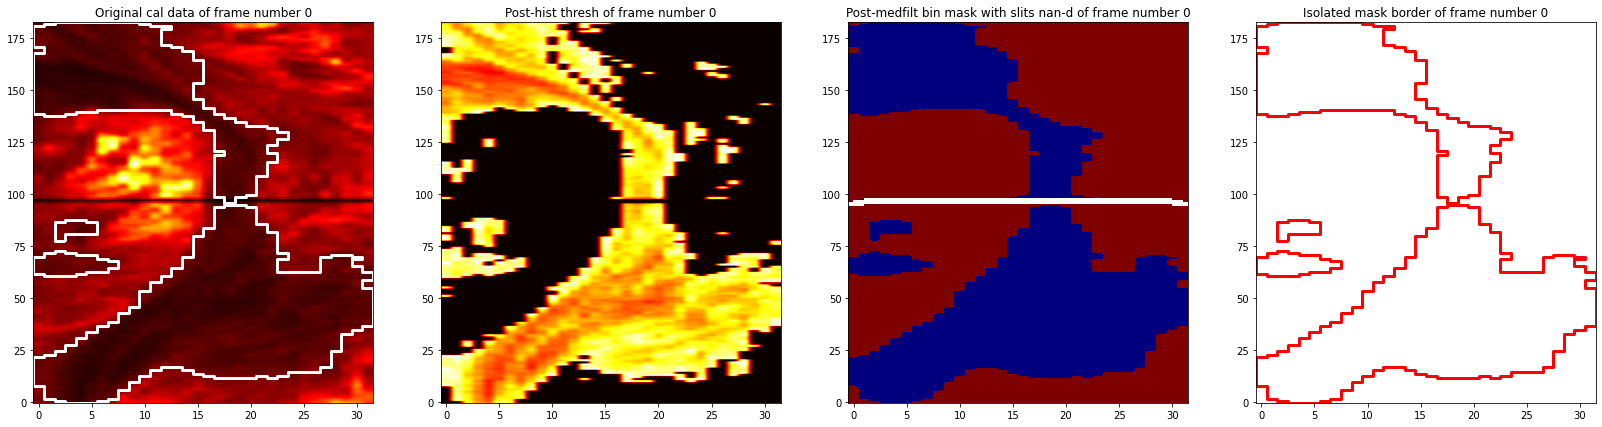

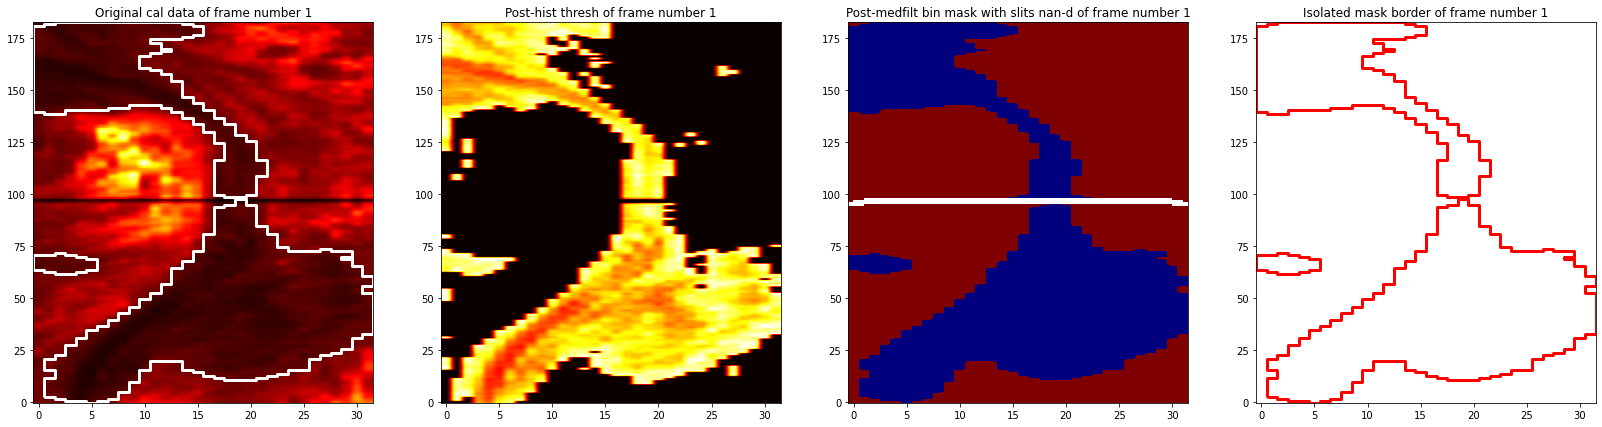

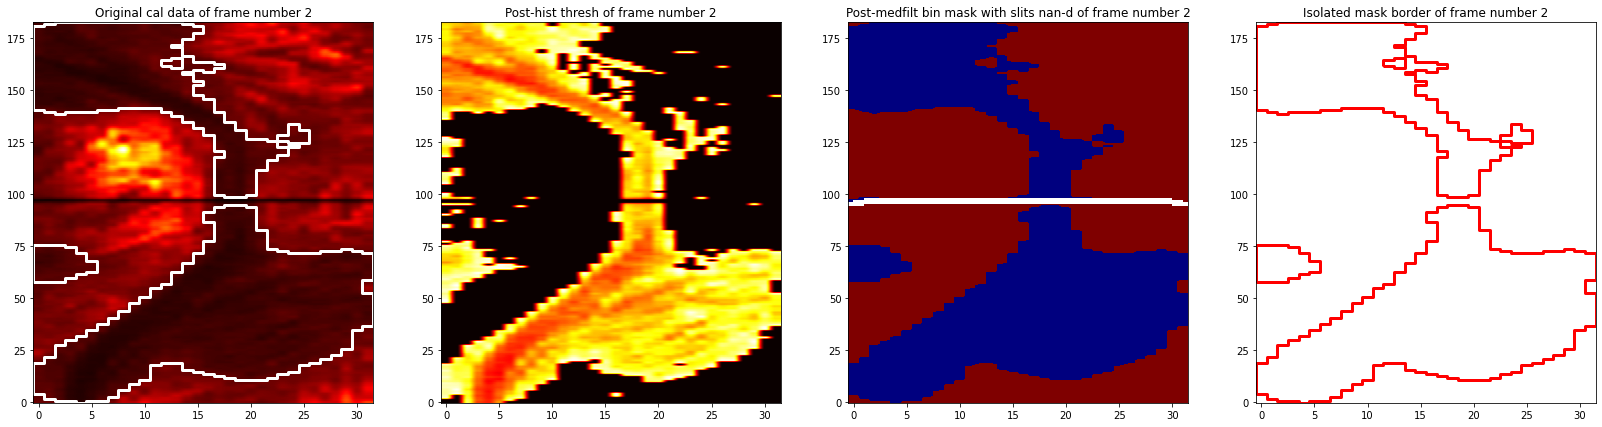

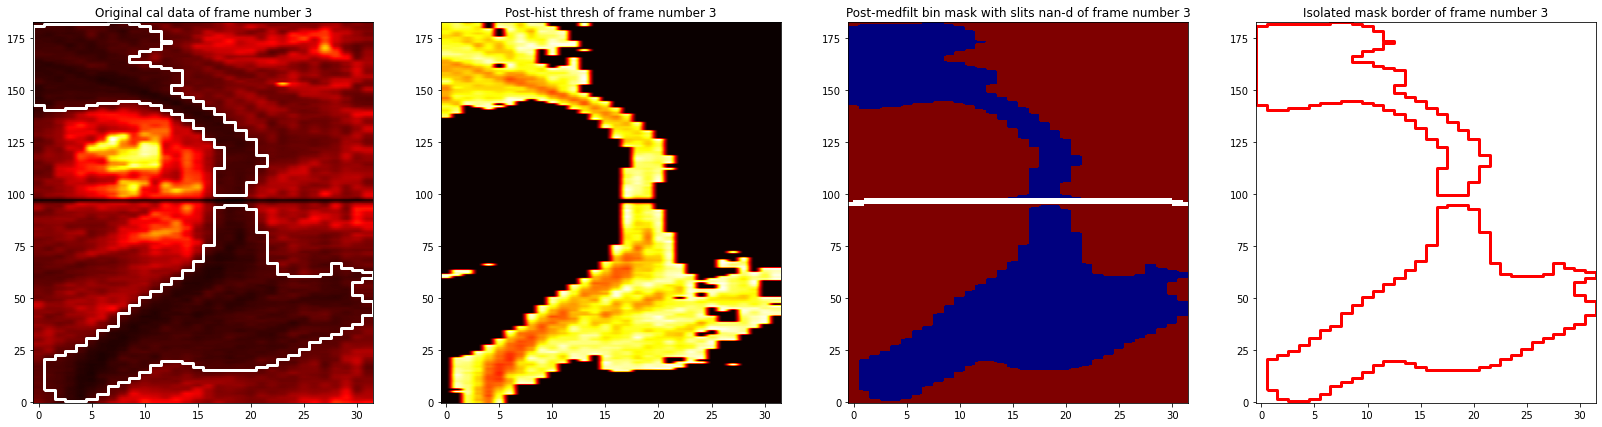

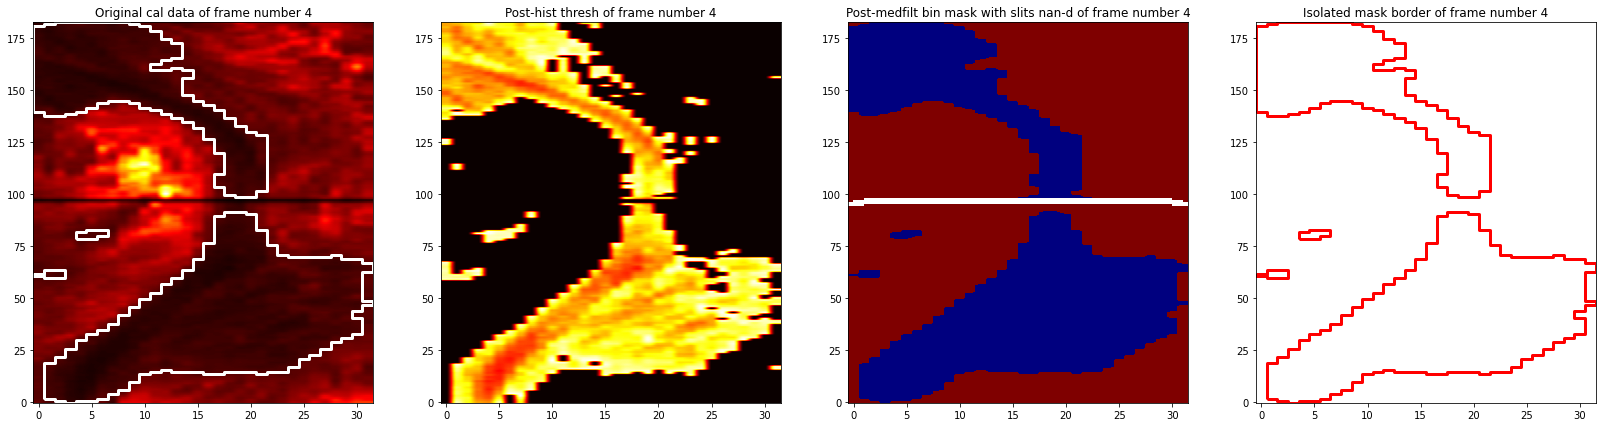

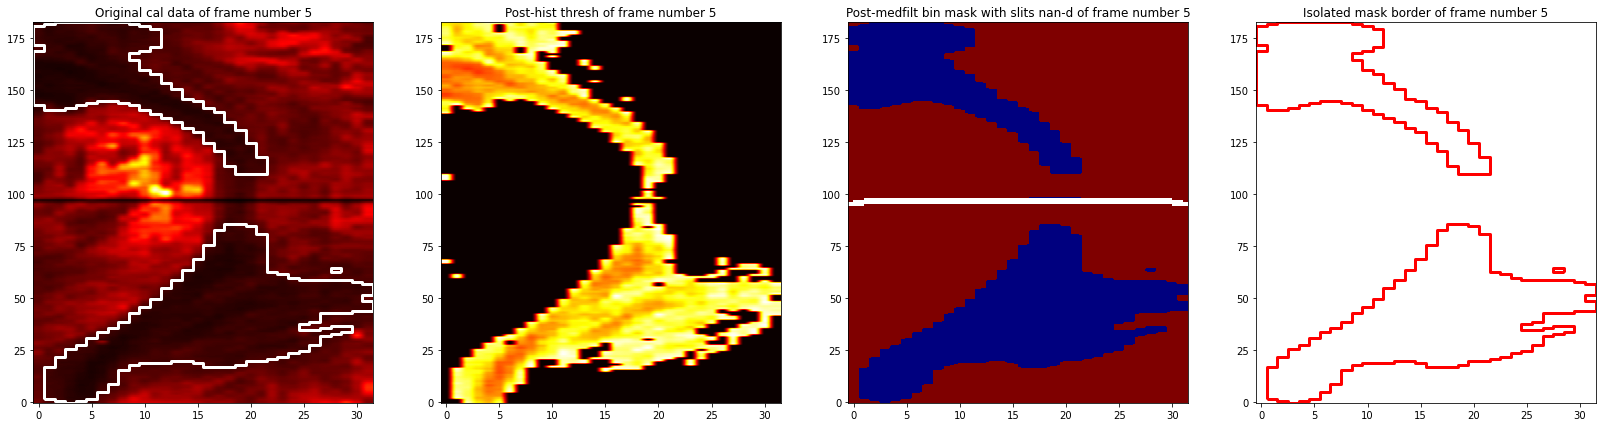

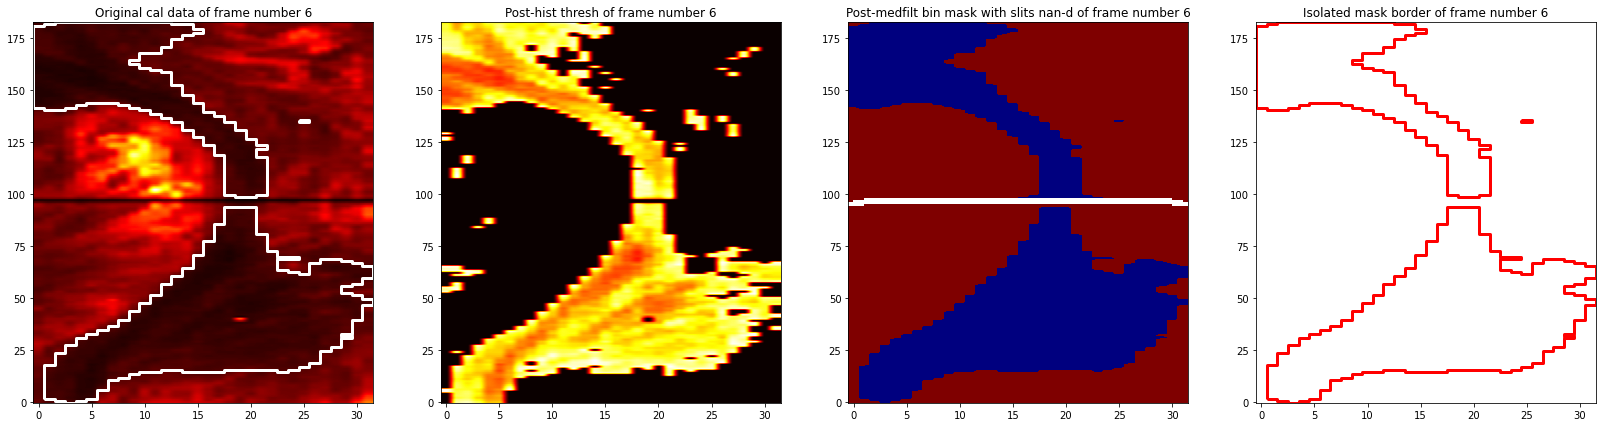

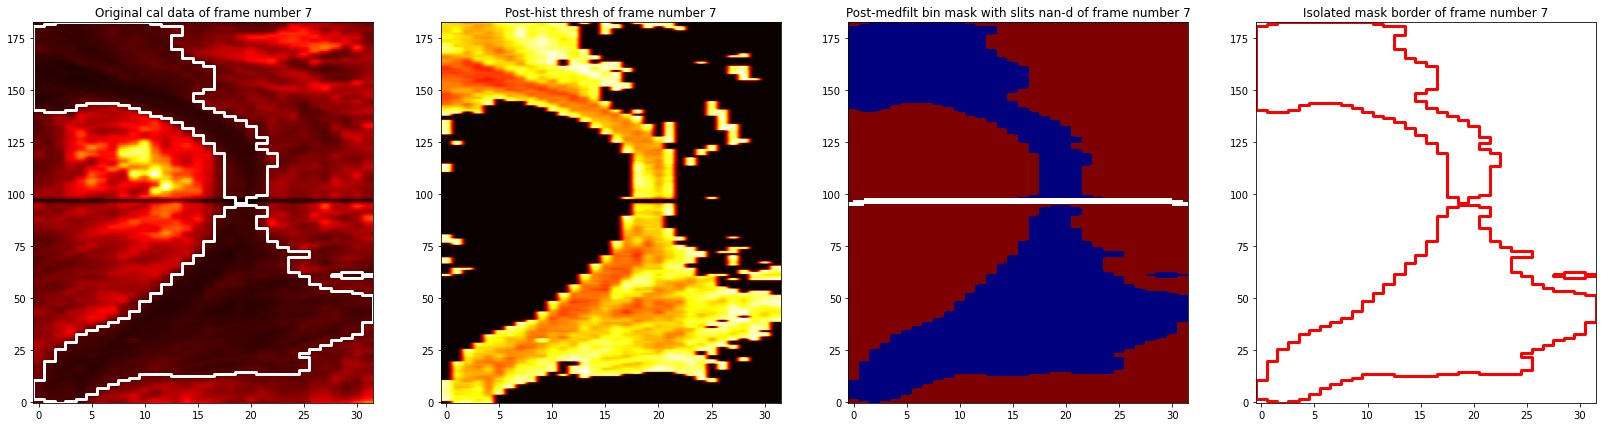

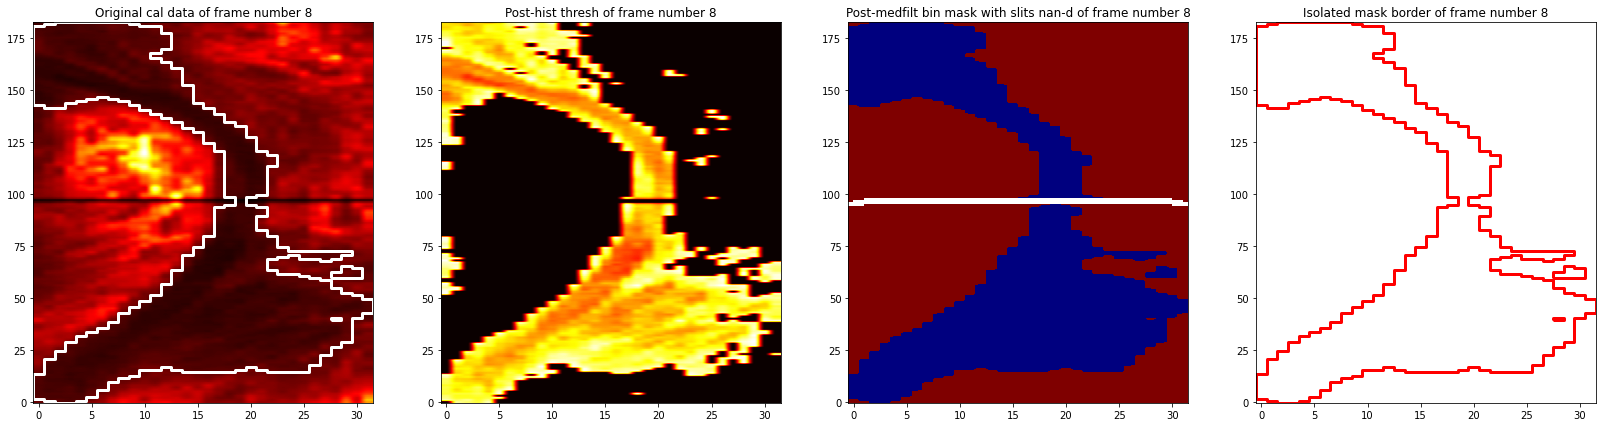

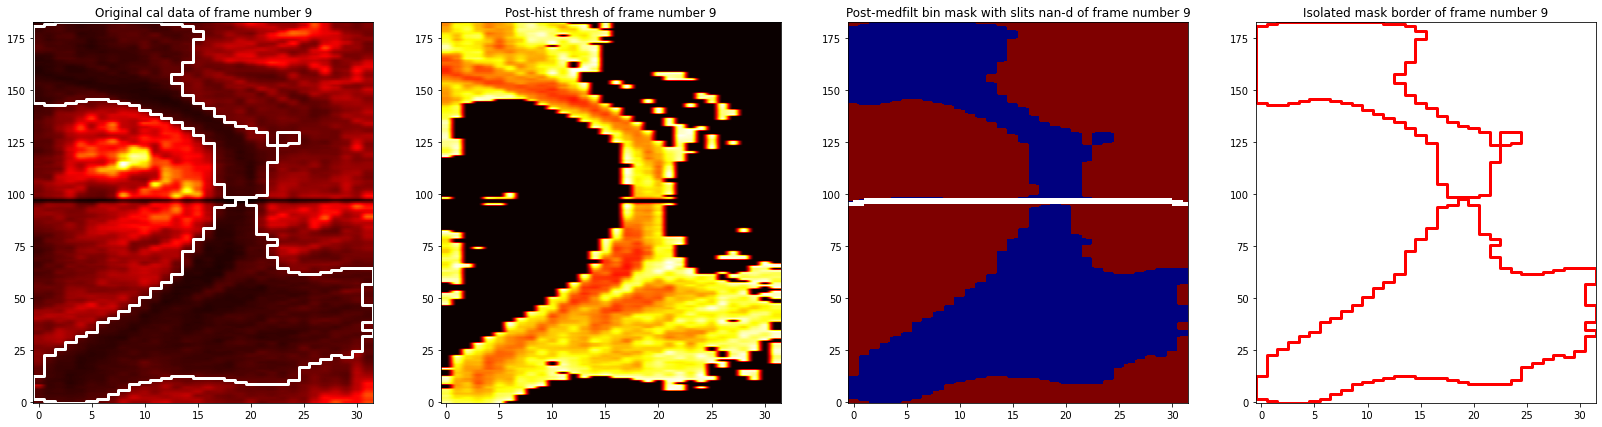

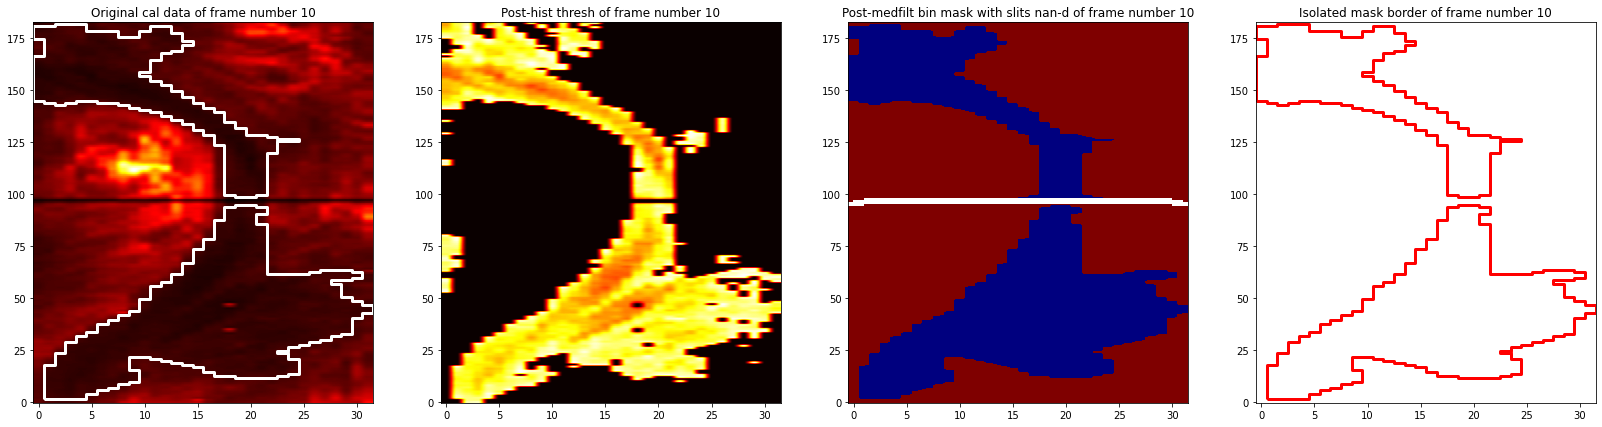

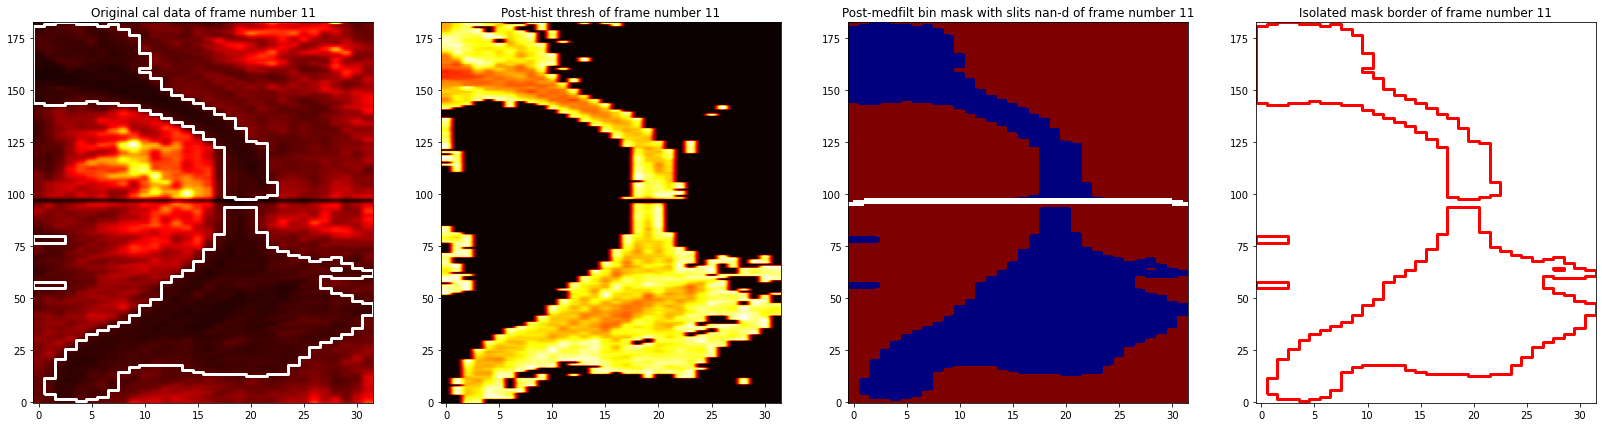

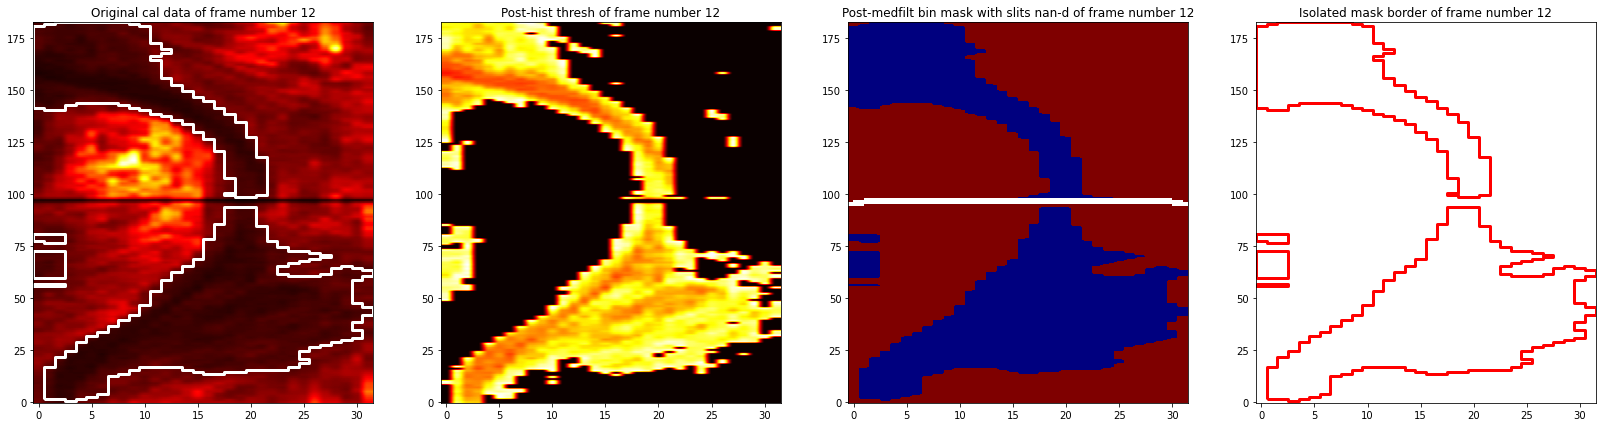

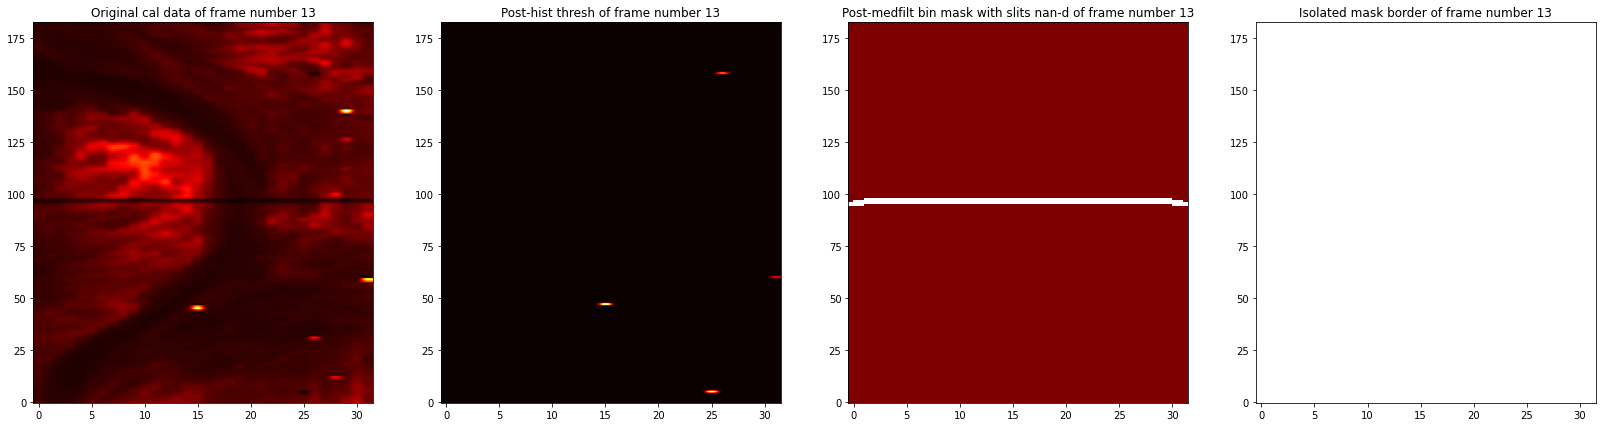

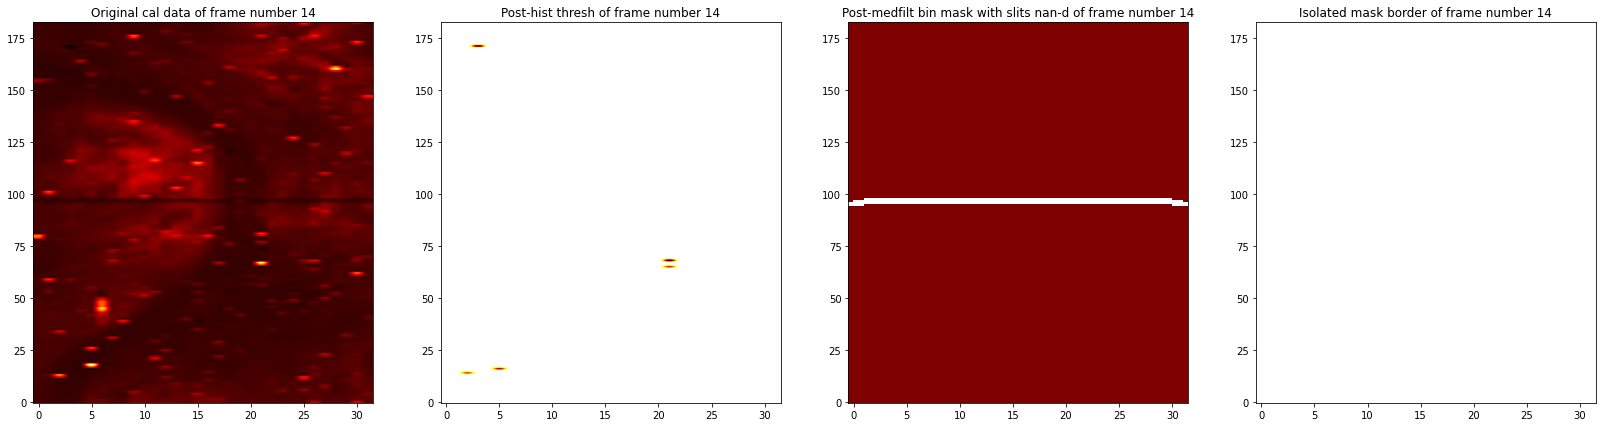

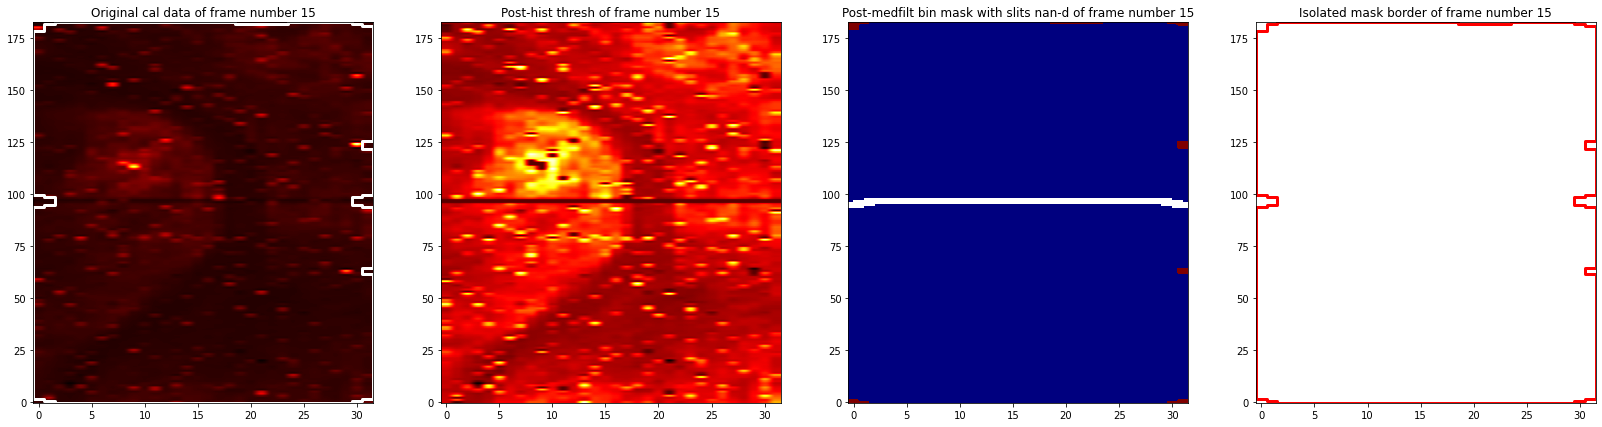

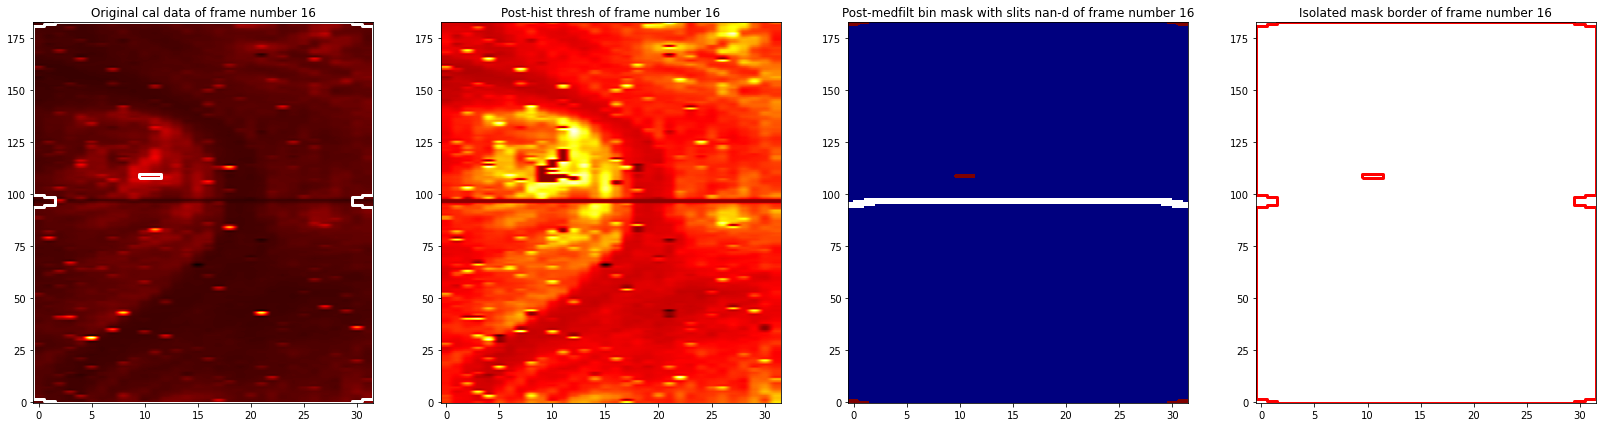

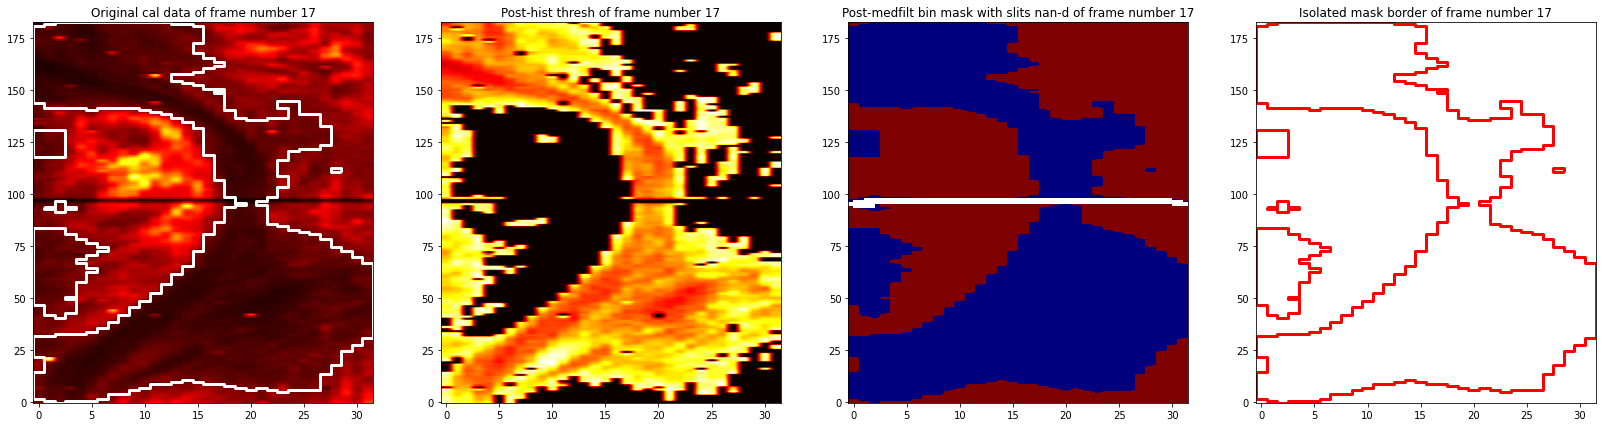

In [8]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

cmap = plt.get_cmap('jet_r', 2)

for frame_ind,frame in enumerate(frame_list):
    frame_original=copy.deepcopy(frame)
    slit_row=slit_row_extract(frame)
    thresh_frame=thresh_extract(frame,slit_row)
    bin_mask_slit=bin_mask_extract(frame,slit_row=slit_row)
    bin_mask_no_slit=bin_mask_extract(frame)
    
    plt.figure(figsize=(28,7))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,1]) 
    
    frame_text=f'of frame number {frame_ind}'
    
    ax0=plt.subplot(gs[0])
    ax1=plt.subplot(gs[1])
    ax2=plt.subplot(gs[2])
    ax3=plt.subplot(gs[3])
    ax0.set(title='Original cal data '+frame_text)
    ax1.set(title='Post-hist thresh '+frame_text)
    ax2.set(title='Post-medfilt bin mask with slits nan-d '+frame_text, facecolor='w')
    ax3.set(title='Isolated mask border '+frame_text)
    
    ax0.imshow(frame_original,aspect='auto',origin='lower',interpolation=None,cmap='hot') # original iris cal data
    ax0.imshow(bin_mask_no_slit, cmap='binary',origin='lower',interpolation=None,alpha=0,aspect='auto')
    plot_world_outlines(bin_mask_no_slit.T, ax=ax0, lw=3, color='w',ls='-')
    ax1.imshow(thresh_frame,aspect='auto',origin='lower',interpolation=None,cmap='hot') # frame threshold using hist method
    ax2.imshow(bin_mask_slit,aspect='auto',origin='lower',interpolation=None,cmap=cmap) # binary map after medfilter
    ax3.imshow(bin_mask_no_slit, cmap='binary',origin='lower',interpolation=None,alpha=0,aspect='auto')
    plot_world_outlines(bin_mask_no_slit.T, ax=ax3, lw=3, color='r',ls='-')


    plt.show()

    